In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost_utils import split_data,create_features,train_and_evaluate,train_and_evaluate_multiple_targets,plot_model_performance
color_pal = sns.color_palette()  
plt.style.use( 'fivethirtyeight' ) 

# Filtrado y Selección de Datos para XGBoost en Series de Tiempo
Preparamos el dataset para entrenar el modelo XGBoost con el propósito de predecir una serie de tiempo. Antes de aplicar el modelo, necesitamos realizar una limpieza y selección de datos para asegurarnos de que solo incluimos las columnas relevantes y los datos de interés.

In [75]:
# Cargar tu dataset (por ejemplo, desde un archivo CSV)
dataset = pd.read_csv("../../data/anexo_circular_7_atencion_primaria.csv")

# Filtrar el dataset donde la columna 'Provincia' sea igual a 'Pinar del Rio'
dataset_filtrado_provincia = dataset[dataset['Provincias'] == 'Pinar del Rio']
# Seleccionar solo las columnas que te interesan
columnas_interes = [
    "TotalAPS_I_Total",
    "TotalAPS_A_Total",
    "TotalAPS_PI_Total",
    "Date"
]

dataset_filtrado = dataset_filtrado_provincia[columnas_interes]

# Mostrar el resultado
dataset_filtrado.head(5)

,TotalAPS_I_Total,TotalAPS_A_Total,TotalAPS_PI_Total,Date
0,10,7,533,2023-04-29
17,84,61,432,2023-01-26
34,45,30,787,2023-04-01
51,45,95,884,2023-08-05
68,124,118,630,2023-03-07


Aqui podremos ver la estructura d nuestro datset y a continuacion veremos la informacion general de nuestro Dataframe

In [76]:
# Asegúrate de que la columna 'Date' esté en formato datetime
dataset_filtrado['Date'] = pd.to_datetime(dataset_filtrado['Date'])

# Ordenar el DataFrame por la columna 'Date' de más reciente a más antigua
df = dataset_filtrado.sort_values(by='Date', ascending=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 1989 to 289
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TotalAPS_I_Total   138 non-null    int64         
 1   TotalAPS_A_Total   138 non-null    int64         
 2   TotalAPS_PI_Total  138 non-null    int64         
 3   Date               138 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.4 KB


/tmp/ipykernel_9359/1389479447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtrado['Date'] = pd.to_datetime(dataset_filtrado['Date'])


Descripción general de cada columna (conteo, la media, la desviación estándar, los valores mínimos y máximos, y los cuartiles)

In [77]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
TotalAPS_I_Total,138.0,90.0,0.0,46.25,79.0,114.25,326.0,63.400707
TotalAPS_A_Total,138.0,91.905797,0.0,43.25,84.5,115.0,429.0,67.681617
TotalAPS_PI_Total,138.0,677.913043,176.0,488.25,664.0,813.75,1290.0,243.661291
Date,138,2023-06-17 14:36:31.304347904,2022-09-18 00:00:00,2023-03-03 18:00:00,2023-07-07 00:00:00,2023-10-07 12:00:00,2023-12-14 00:00:00,NaN


Cantidad de valores únicos para cada columna

In [78]:
df.nunique()

TotalAPS_I_Total      97
TotalAPS_A_Total      99
TotalAPS_PI_Total    122
Date                 137
dtype: int64

Como podemos observar hay 137 valores unicos en las fechas, por lo q deberia haber 138, eso significa que hay una fecha repetida y lo que vamos a hacer para solucionarlo es modificar esa fecha por el dia siguiente o el anterior, en dependencia de lo que falte en nuestro dataset

In [79]:
# Identificar fechas duplicadas
duplicated_dates = df[df['Date'].duplicated(keep=False)]

print(duplicated_dates)
# Procesar cada duplicado
for index, row in duplicated_dates.iterrows():
    current_date = row['Date']
    one_day_before = current_date - pd.Timedelta(days=1)
    one_day_after = current_date + pd.Timedelta(days=1)
    
    # Verificar si existe un día antes o después en el dataset
    if one_day_after not in df['Date'].values:
        df.at[index, 'Date'] = one_day_after
        break
    elif one_day_before not in df['Date'].values:
        df.at[index, 'Date'] = one_day_before
    else:
        print(f"No se pudo ajustar la fecha duplicada: {current_date}")

# Verificar si se resolvieron los duplicados
remaining_duplicates = df[df['Date'].duplicated(keep=False)]
if not remaining_duplicates.empty:
    print("Todavía quedan duplicados:")
    print(remaining_duplicates)
else:
    print("Fechas duplicadas resueltas.")


      TotalAPS_I_Total  TotalAPS_A_Total  TotalAPS_PI_Total       Date
1411               110                94                696 2023-09-03
1904                49                38                680 2023-09-03
Fechas duplicadas resueltas.


# Falta de datos

Para manejar la falta de datos decidimos anadir de todos los dias faltantes y autocompletar los datos con la media

In [80]:
# Crear un rango continuo de fechas desde la más antigua hasta la más reciente
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())

# Crear un DataFrame con todas las fechas
all_dates_df = pd.DataFrame({'Date': all_dates})

# Hacer un merge con el DataFrame original para incluir todas las fechas
df = all_dates_df.merge(df, on='Date', how='left')

# Rellenar las columnas faltantes con la moda
# Suponiendo que las otras columnas son numéricas o categóricas:
for column in df.columns:
    if column != 'Date':  # Ignorar la columna de fecha
        column_mode = df[column].mode()[0]  # Calcular la moda de la columna
        column_mean = df[column].mean()  # Calcular la mediana de la columna
        column_median = df[column].median()  # Calcular la mediana de la columna

                                    # ponga aqui con cual columna desea rellenar el dato, moda, media o mediana
        df[column] = df[column].fillna(column_mode)  # Rellenar los valores faltantes con la moda

# Dividir los datos en entrenamiento y prueba
Antes de crear las características de lags y ventanas móviles, divide el conjunto de datos en entrenamiento y prueba basándote en la fecha. Esto es importante para las series temporales, ya que debes respetar la secuencia temporal.

In [81]:
train_data ,test_data = split_data(df,0.8)

# Crear características para entrenamiento y prueba
Crea las mismas características (lags, ventanas móviles, etc.) para ambos subconjuntos de datos.

In [82]:
# Columnas objetivo
target_cols = ['TotalAPS_I_Total', 'TotalAPS_A_Total', 'TotalAPS_PI_Total']

# Generar características para entrenamiento y prueba
train_data = create_features(train_data, target_cols, lags=1,wind=2)
test_data = create_features(test_data, target_cols, lags=1,wind=2)

/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['Date'].dt.year
/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.month
/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# Entrenar y evaluar modelos
Entrena un modelo para cada columna objetivo y evalúa su rendimiento en el conjunto de prueba.

In [83]:
_,predictions=train_and_evaluate_multiple_targets(train_data, test_data, target_cols, date_col='Date')

Entrenando modelo para: TotalAPS_I_Total
TotalAPS_I_Total - RMSE: 5.40473043833928, MSE: 29.211111111111112, MAE: 2.6777777777777776
Entrenando modelo para: TotalAPS_A_Total
TotalAPS_A_Total - RMSE: 14.827901627225165, MSE: 219.86666666666667, MAE: 7.133333333333334
Entrenando modelo para: TotalAPS_PI_Total
TotalAPS_PI_Total - RMSE: 47.56002055882183, MSE: 2261.9555555555557, MAE: 20.68888888888889


# Comparar predicciones con valores reales
Grafica los resultados del conjunto de prueba para visualizar el desempeño del modelo.

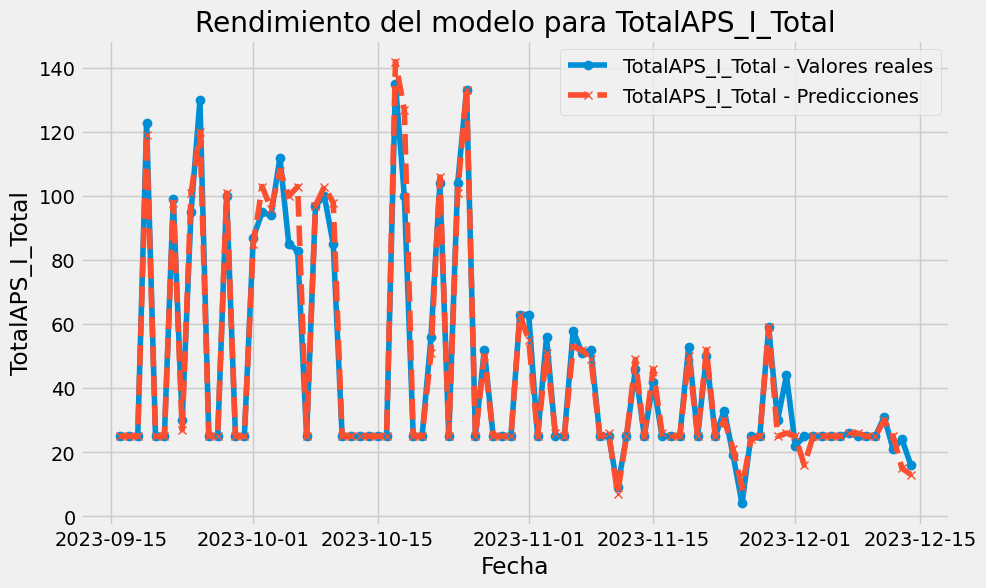

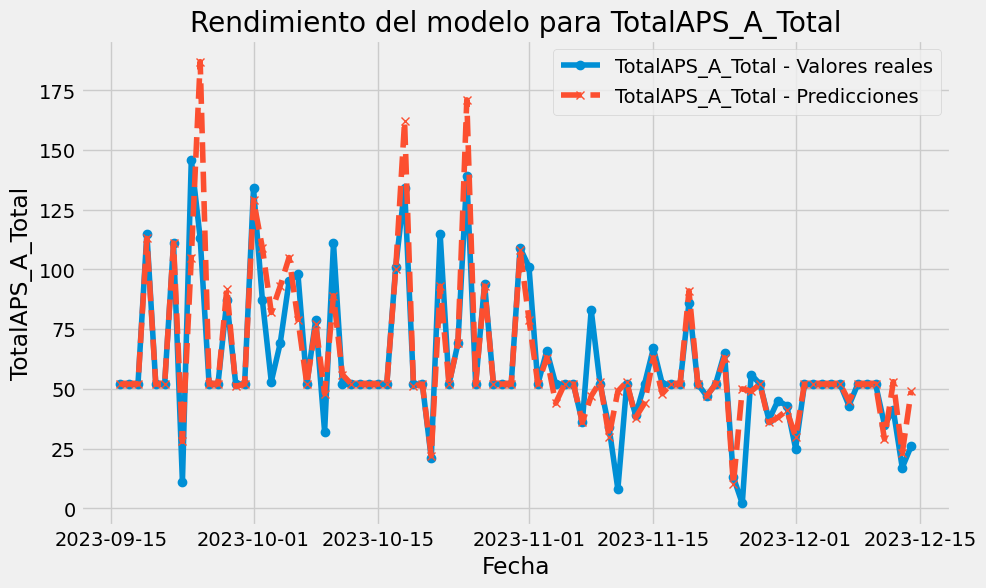

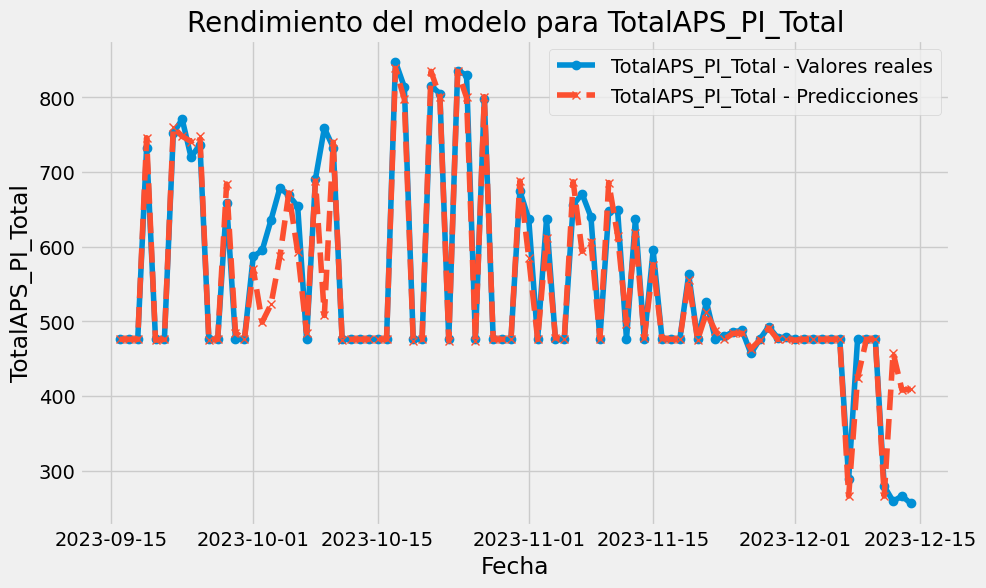

In [84]:
plot_model_performance(test_data, target_cols, predictions)

# Probando con otros datos

In [88]:
# Cargar tu dataset (por ejemplo, desde un archivo CSV)
train_data = pd.read_csv("../../data/total_incomes_augmented_training_data.csv")
test_data = pd.read_csv("../../data/total_incomes_test_data.csv")

# # Concatenar los DataFrames
df = pd.concat([train_data, test_data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])

# # Ordenar el DataFrame por la columna 'Date' de más reciente a más antigua
df = df.sort_values(by='Date', ascending=True)

columnas_a_sumar = [
    'Pinar del Rio',
    'Artemisa',
    'La Habana',
    'Mayabeque',
    'Matanzas',
    'Villa Clara',
    'Cienfuegos',
    'Sancti Spiritus',
    'Ciego de Ávila',
    'Camagüey',
    'Las Tunas',
    'Holguin',
    'Granma',
    'Santiago de Cuba',
    'Guantánamo',
    'Isla de la Juventud'
    ]

df['total_aps_i_pais'] = df[columnas_a_sumar].sum(axis=1)

train_data ,test_data = split_data(df,0.8)

# # Seleccionar solo las columnas que te interesan
columnas_interes_provincias = [
    "Date",
    'Pinar del Rio',
    'Artemisa',
    'La Habana',
    'Mayabeque',
    'Matanzas',
    'Villa Clara',
    'Cienfuegos',
    'Sancti Spiritus',
    'Ciego de Ávila',
    'Camagüey',
    'Las Tunas',
    'Holguin',
    'Granma',
    'Santiago de Cuba',
    'Guantánamo',
    'Isla de la Juventud'
]

# Seleccionar solo las columnas que te interesan
columnas_interes_pais = ["Date",'total_aps_i_pais']

train_data_provincias = train_data[columnas_interes_provincias]
test_data_provincias = test_data[columnas_interes_provincias]

train_data_pais = train_data[columnas_interes_pais]
test_data_pais = test_data[columnas_interes_pais]

# Mostrar el resultado
train_data_provincias.head(5)
train_data_pais.head(5)

,Date,total_aps_i_pais
0,2022-09-19,2309.0
1,2022-09-20,4850.0
2,2022-09-21,4531.0
3,2022-09-22,4611.0
4,2022-09-23,4275.0


In [89]:
# Columnas objetivo
target_cols_provincia = ['Pinar del Rio','Artemisa','La Habana','Mayabeque','Matanzas','Villa Clara','Cienfuegos','Sancti Spiritus','Ciego de Ávila','Camagüey','Las Tunas','Holguin','Granma','Santiago de Cuba','Guantánamo','Isla de la Juventud']
target_cols_pais = ['total_aps_i_pais']

# Generar características para entrenamiento y prueba
train_data_provincias = create_features(train_data_provincias, target_cols_provincia,lags=1,wind=2)
test_data_provincias = create_features(test_data_provincias, target_cols_provincia,lags=1,wind=2)

train_data_pais = create_features(train_data_pais, target_cols_pais)
test_data_pais = create_features(test_data_pais, target_cols_pais)

/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['Date'].dt.year
/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.month
/home/dario/Study/ml/polyclinic-ml-project/src/XGBoost/xgboost_utils.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [90]:
_,predictions_provincias=train_and_evaluate_multiple_targets(train_data_provincias, test_data_provincias, target_cols_provincia)
_,predictions_pais=train_and_evaluate_multiple_targets(train_data_pais, test_data_pais, target_cols_pais)

Entrenando modelo para: Pinar del Rio
Pinar del Rio - RMSE: 10.379122818243866, MSE: 107.72619047619048, MAE: 6.964285714285714
Entrenando modelo para: Artemisa
Artemisa - RMSE: 11.428348212105846, MSE: 130.60714285714286, MAE: 8.226190476190476
Entrenando modelo para: La Habana
La Habana - RMSE: 11.757976016304847, MSE: 138.25, MAE: 8.345238095238095
Entrenando modelo para: Mayabeque
Mayabeque - RMSE: 7.274384280931732, MSE: 52.916666666666664, MAE: 5.011904761904762
Entrenando modelo para: Matanzas
Matanzas - RMSE: 5.027306388495685, MSE: 25.273809523809526, MAE: 3.511904761904762
Entrenando modelo para: Villa Clara
Villa Clara - RMSE: 23.152702197532346, MSE: 536.047619047619, MAE: 16.452380952380953
Entrenando modelo para: Cienfuegos
Cienfuegos - RMSE: 5.686240703077327, MSE: 32.333333333333336, MAE: 3.7142857142857144
Entrenando modelo para: Sancti Spiritus
Sancti Spiritus - RMSE: 13.324699585642412, MSE: 177.54761904761904, MAE: 9.952380952380953
Entrenando modelo para: Ciego de 

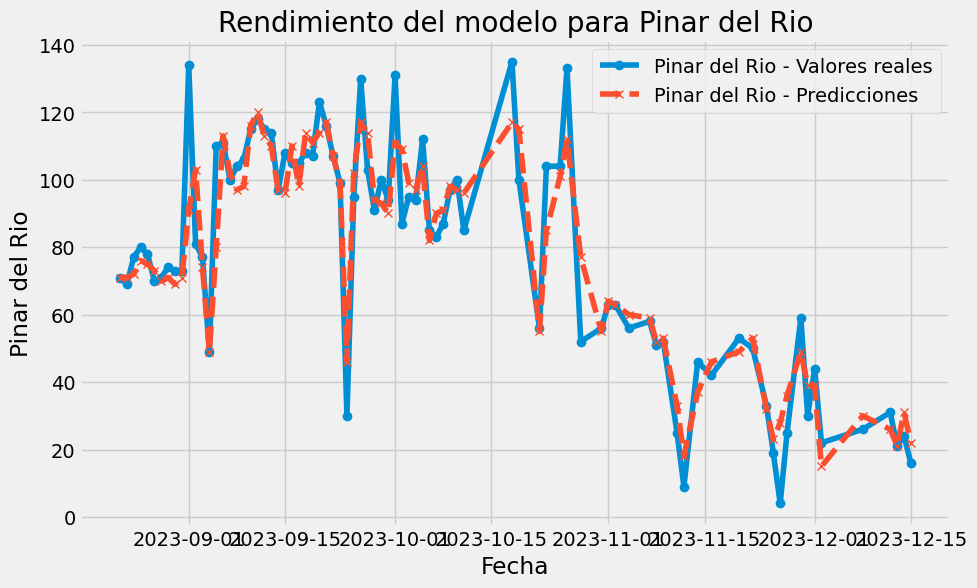

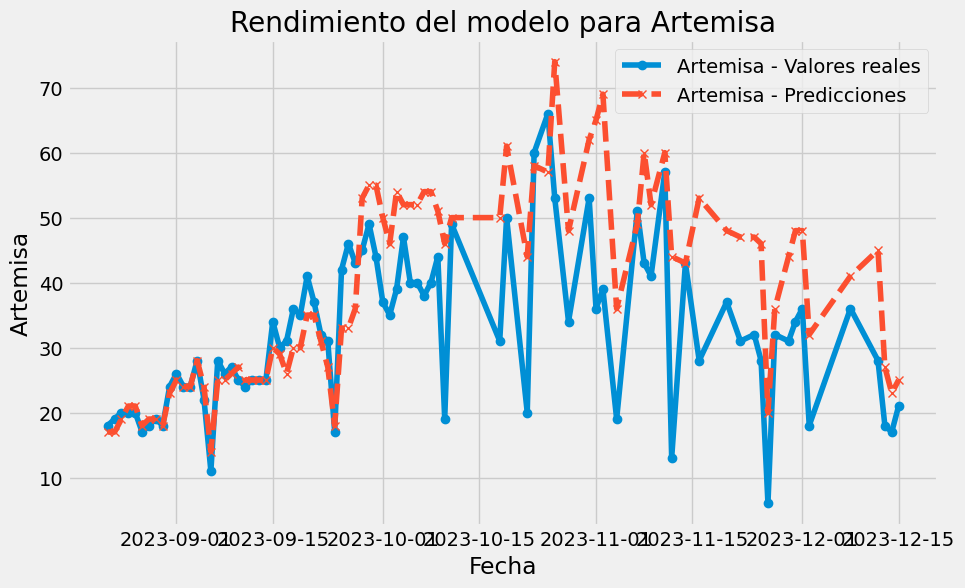

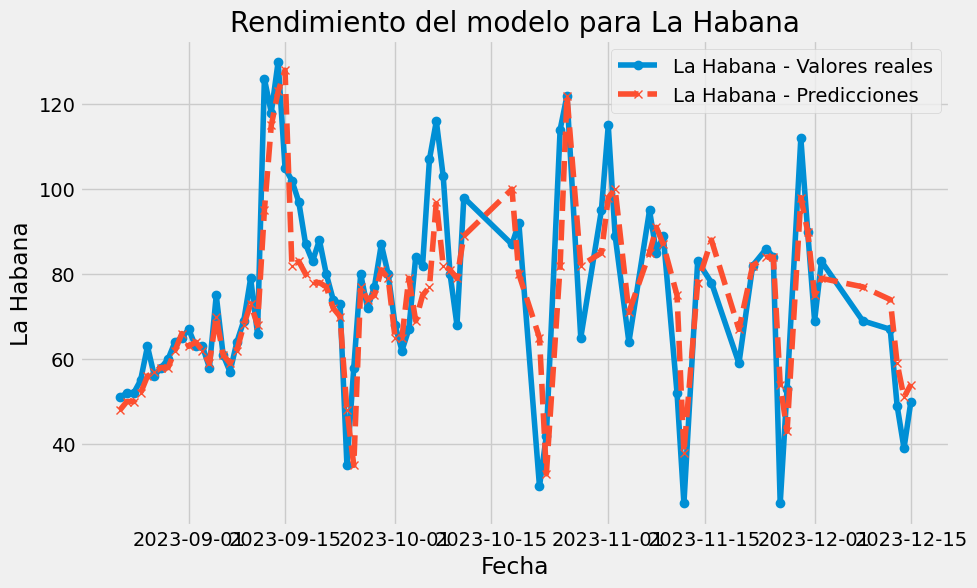

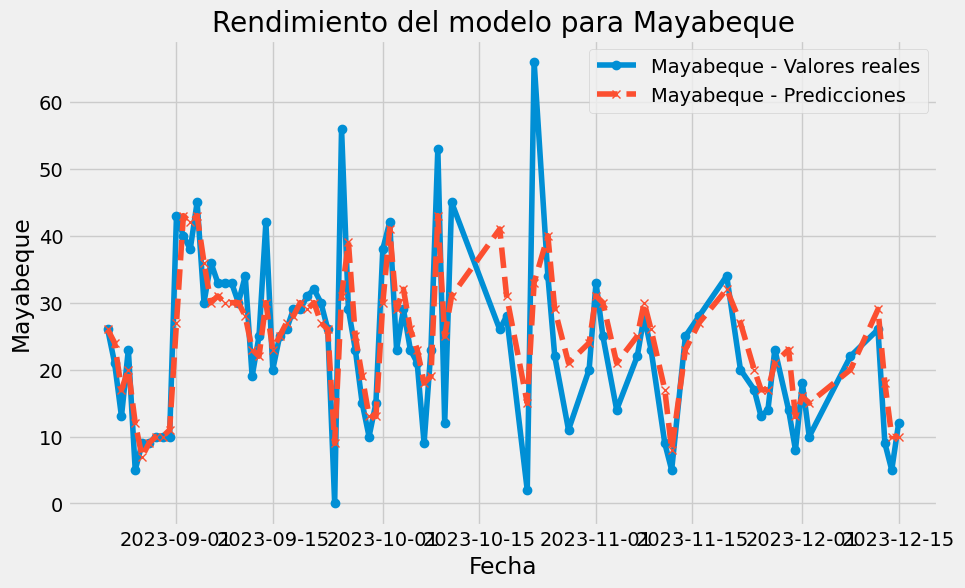

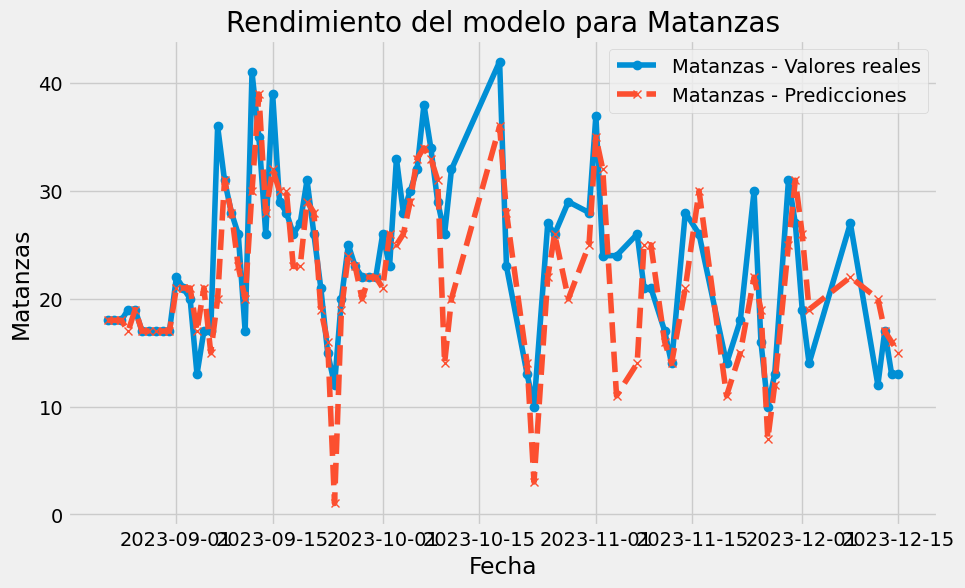

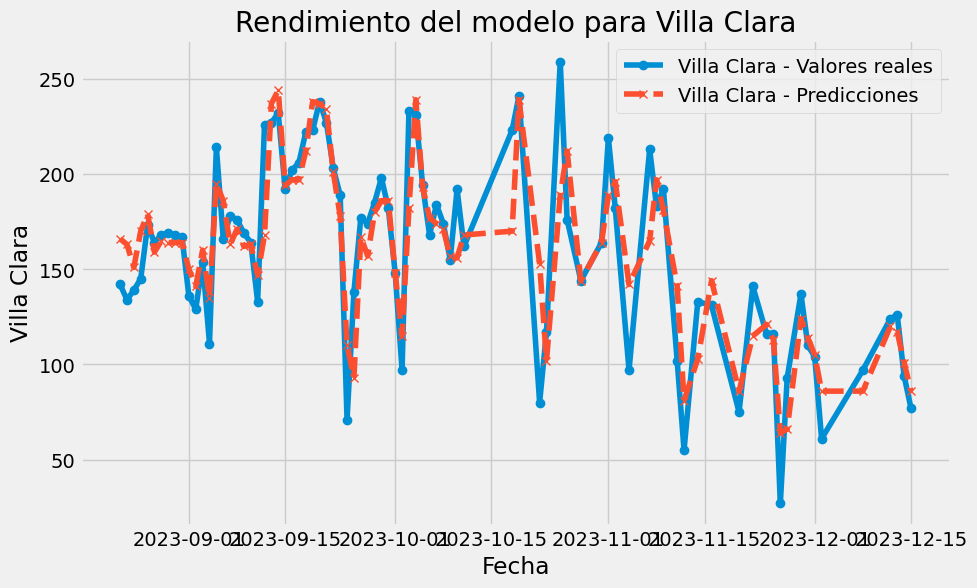

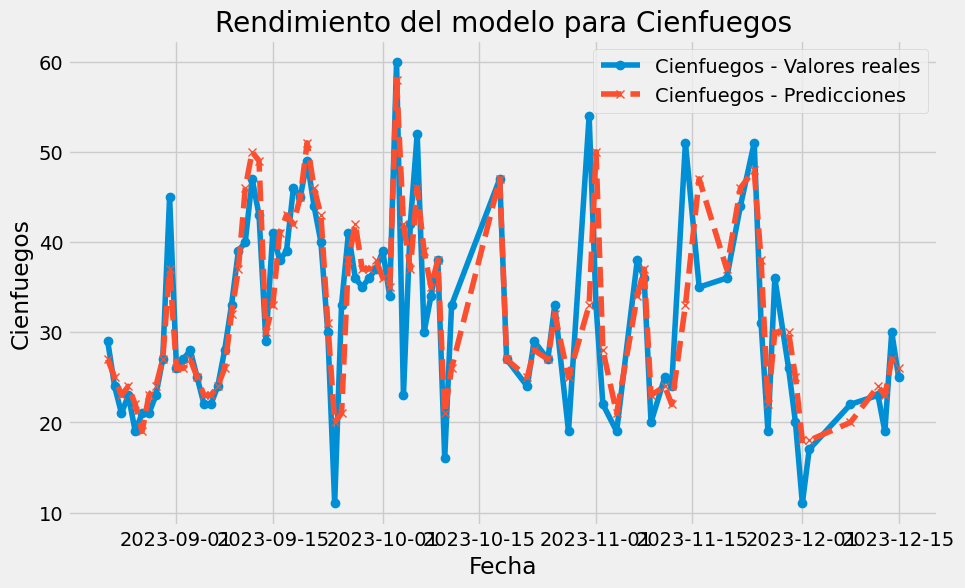

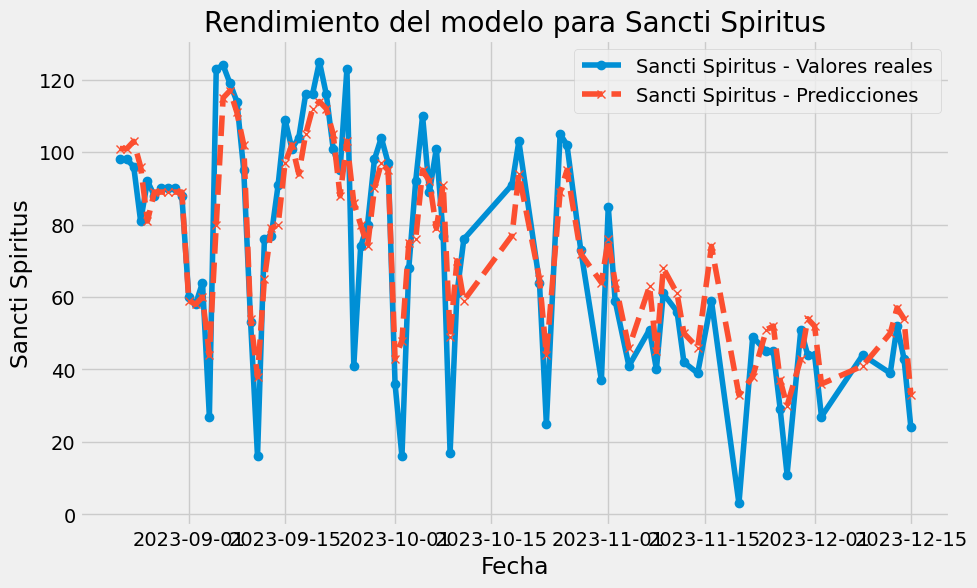

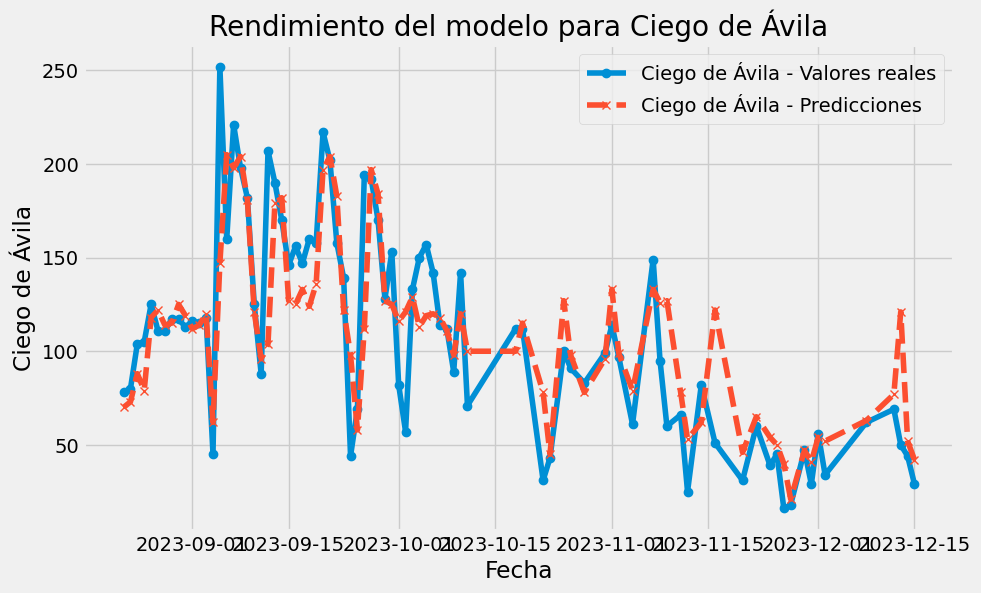

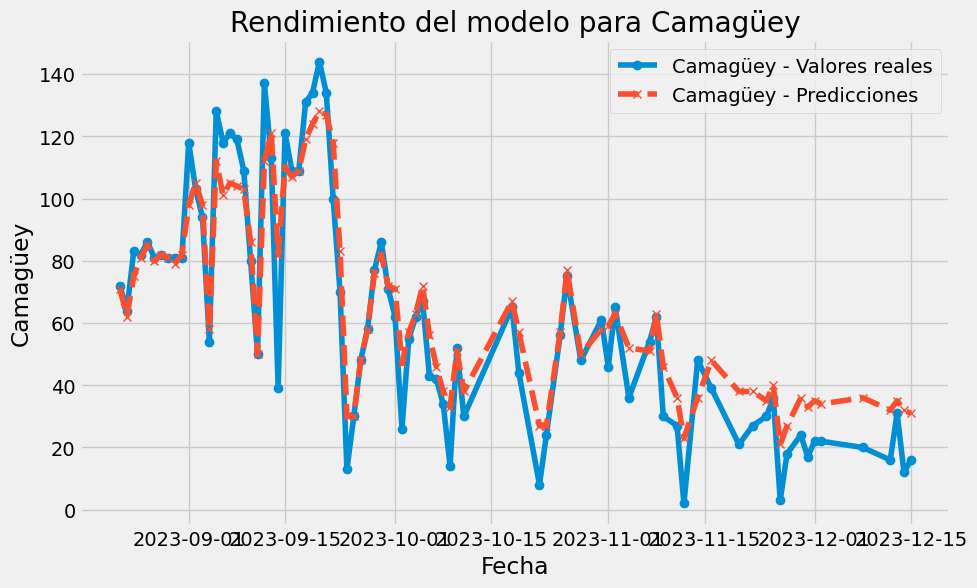

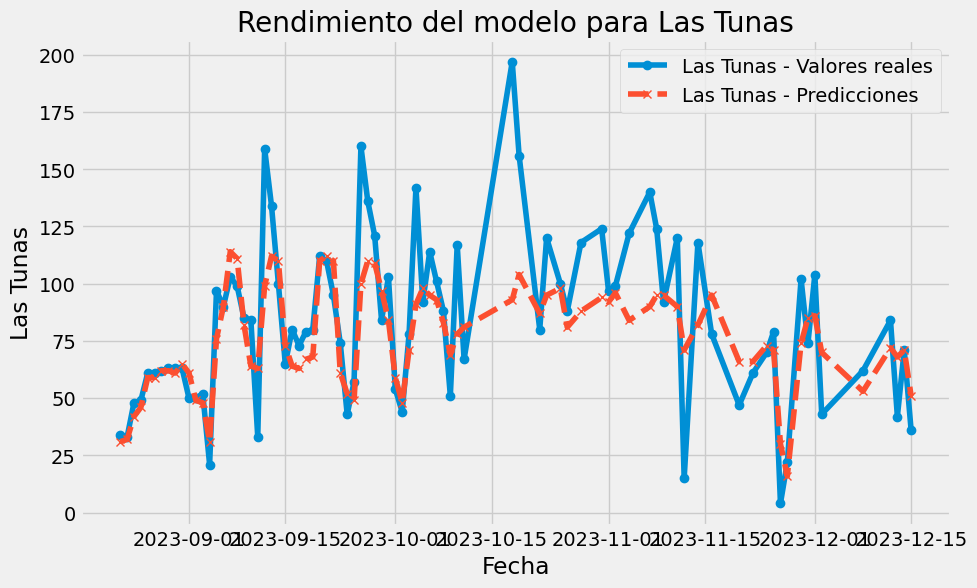

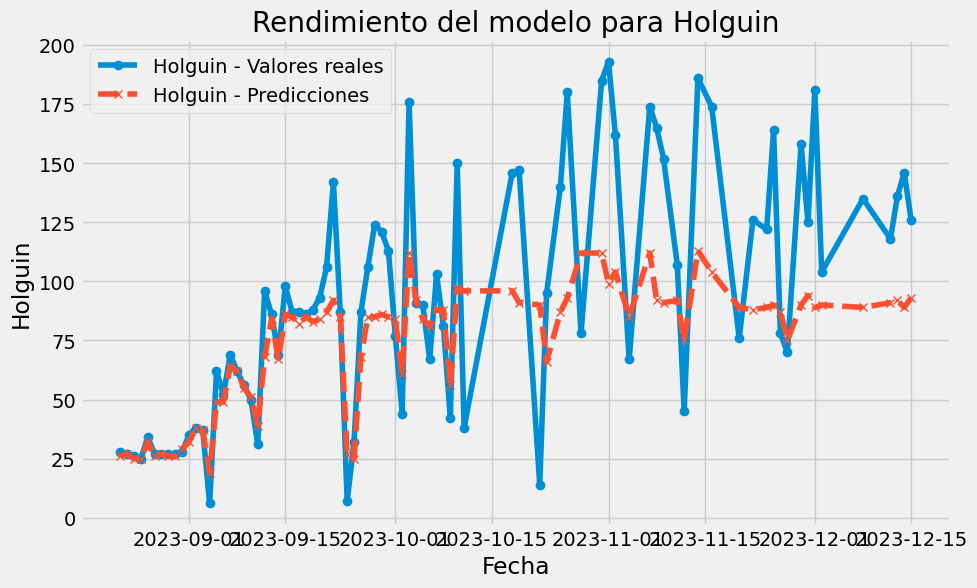

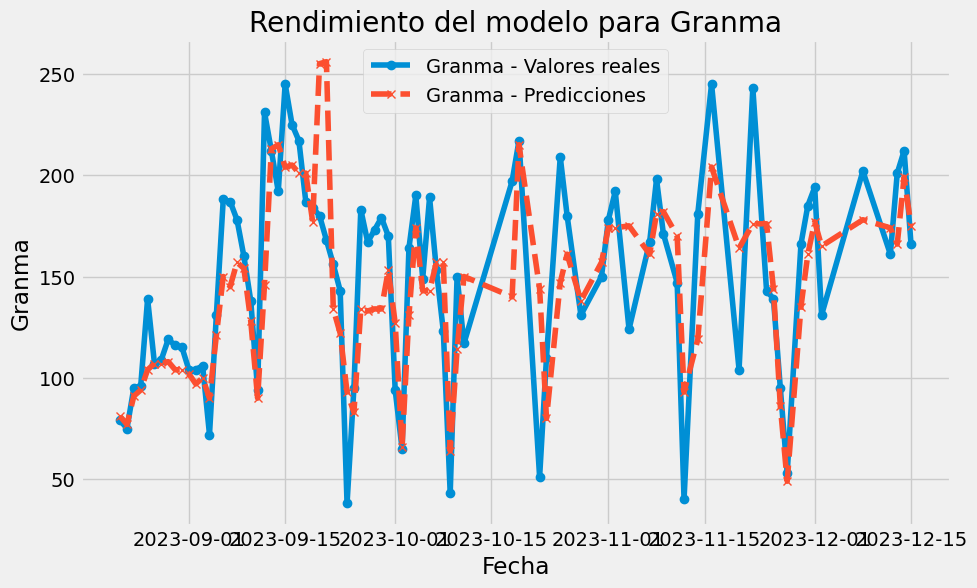

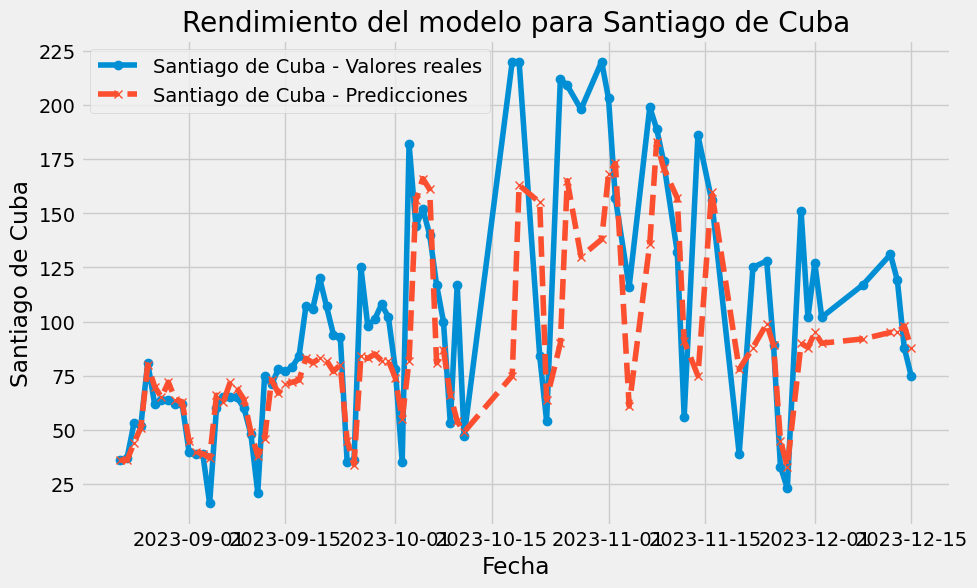

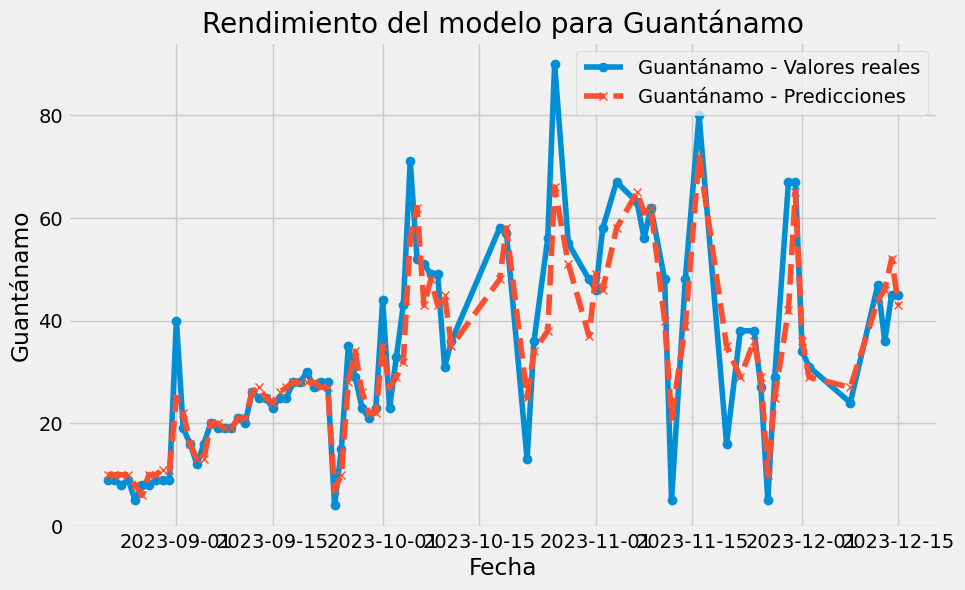

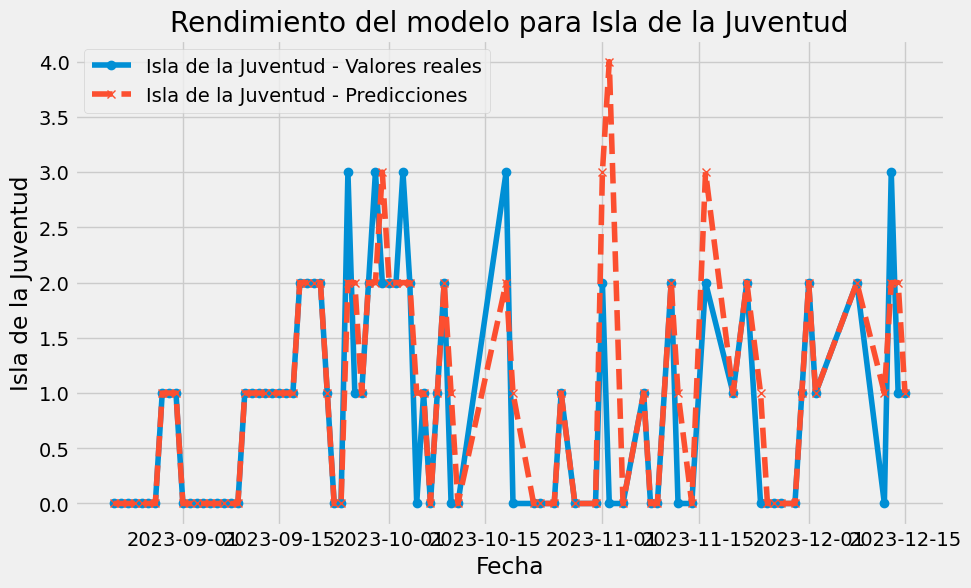

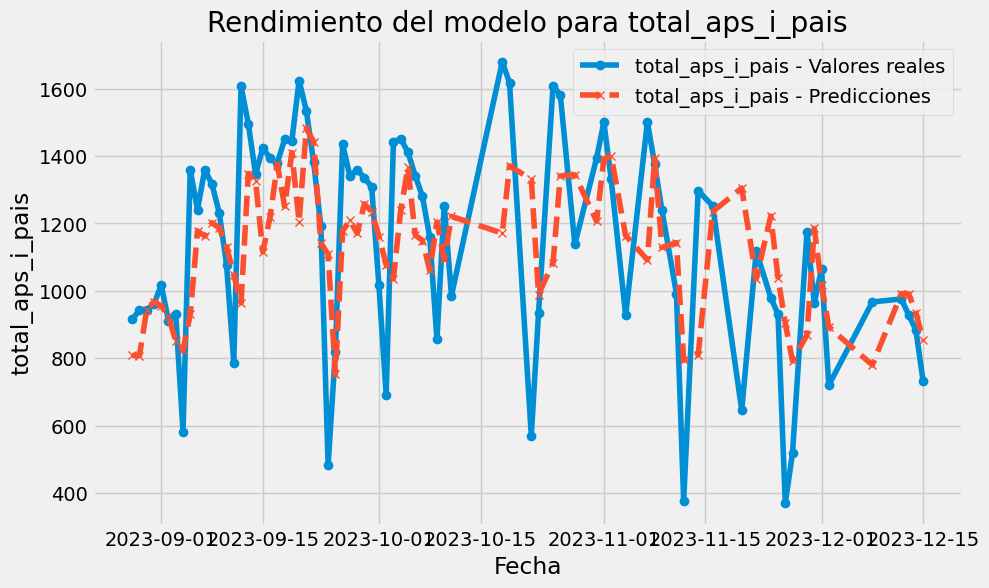

In [91]:
plot_model_performance(test_data_provincias, target_cols_provincia, predictions_provincias)
plot_model_performance(test_data_pais, target_cols_pais, predictions_pais)